In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

### Load data

In [2]:
# Lets read the train data and the train labels. 
train_data_directory = 'D:/Brain_Tumor_Data/train'
data_directory = 'D:/Brain_Tumor_Data'
IMAGE_SIZE = 128
NUM_IMAGES = 64
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="T1w", split="test", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

(1, 128, 128, 64)
0.0 1.0 0.3975705077603092 0.7483399765459943
Dimension of the CT scan is: (128, 128, 64)


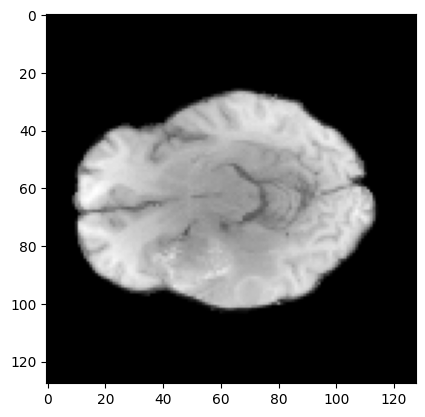

In [3]:
a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

In [4]:
df_train_labels = pd.read_csv('D:/Brain_Tumor_Data/_labels.csv')
df_train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [5]:
train_data_directory = 'D:/Brain_Tumor_Data/train'
print(min(os.listdir(train_data_directory)), max(os.listdir(train_data_directory)))

00000 01010


In [6]:
total_training_scans_T1 = np.array([load_dicom_images_3d(a, split = 'train', mri_type="T1w") for a in os.listdir(train_data_directory)])

In [7]:
len(total_training_scans_T1)

585

(585, 1, 128, 128, 64)
585
Dimension of the CT scan is: (1, 128, 128, 64)


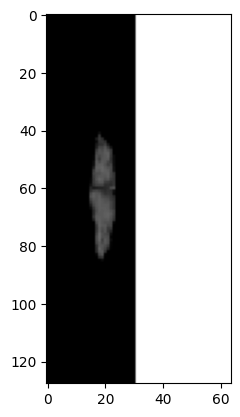

In [8]:
print(total_training_scans_T1.shape)
print(len(total_training_scans_T1))
image = total_training_scans_T1[20]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 25]), cmap="gray")

In [9]:
# Split data in the ratio 70-30 for training and validation.
x_train_T1 = np.array([train.T for train in total_training_scans_T1[:410]])
x_val_T1 = np.array([train.T for train in total_training_scans_T1[410:]])

In [10]:
print(f"The shape of train: {x_train_T1.shape}")

The shape of train: (410, 64, 128, 128, 1)


In [11]:
print(f"The shape of val: {x_val_T1.shape}")

The shape of val: (175, 64, 128, 128, 1)


In [12]:
total_training_labels = df_train_labels["MGMT_value"].to_list()

In [13]:
total_training_labels = total_training_labels[:585]

In [14]:
len(total_training_labels)

585

In [15]:
y_train = total_training_labels[:410]
y_val = total_training_labels[410:]

### Model

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [17]:
def get_model(drop_out, with_data_aug, width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,width, height,1))
    if (with_data_aug):
        x = data_augmentation(inputs)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(drop_out)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [18]:
with tf.device('/device:GPU:0'):
    auc_list = []
    auc_with_data_aug = []
    count = 0
    for i in np.arange(0, 1, 0.1):
        for j in np.arange(2):
            # Build model.
            model = get_model(drop_out = i, with_data_aug = j, width=128, height=128, depth=64)

            # Compile model.
            initial_learning_rate = 0.0001
            lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
            )
            model.compile(
                loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
            )

            # Define callbacks.
            checkpoint_cb = keras.callbacks.ModelCheckpoint(
               f"Drop_out_{i}.h5", save_best_only=True
            )
            # 
            early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)  # TODO

            # Train the model, doing validation at the end of each epoch
            epochs = 10
            history = model.fit(
                tf.data.Dataset.from_tensor_slices((x_train_T1, y_train)).batch(4),
                validation_data=tf.data.Dataset.from_tensor_slices((x_val_T1,y_val)).batch(4),
                epochs=epochs,
                shuffle=True,
                verbose=2,
                callbacks=[checkpoint_cb, early_stopping_cb],
            )
            if (count > 0):
                if (j):
                    auc_with_data_aug.append(history.history[f'val_auc_{count}'][-1])
                else:
                    auc_list.append(history.history[f'val_auc_{count}'][-1])
            else:
                if (j):
                    auc_with_data_aug.append(history.history['val_auc'][-1])
                else:
                    auc_list.append(history.history['val_auc'][-1])
            
            count += 1
        print(i)

Epoch 1/10
103/103 - 53s - loss: 0.7168 - auc: 0.5410 - acc: 0.5195 - val_loss: 0.7154 - val_auc: 0.4675 - val_acc: 0.4343 - 53s/epoch - 514ms/step
Epoch 2/10
103/103 - 31s - loss: 0.6849 - auc: 0.5985 - acc: 0.5659 - val_loss: 0.7745 - val_auc: 0.4681 - val_acc: 0.4343 - 31s/epoch - 296ms/step
Epoch 3/10
103/103 - 31s - loss: 0.6558 - auc: 0.6506 - acc: 0.6073 - val_loss: 0.7584 - val_auc: 0.4645 - val_acc: 0.4343 - 31s/epoch - 297ms/step
Epoch 4/10
103/103 - 31s - loss: 0.6181 - auc: 0.7167 - acc: 0.6610 - val_loss: 0.7626 - val_auc: 0.4282 - val_acc: 0.4457 - 31s/epoch - 300ms/step
Epoch 5/10
103/103 - 31s - loss: 0.5900 - auc: 0.7614 - acc: 0.7146 - val_loss: 0.7454 - val_auc: 0.4314 - val_acc: 0.4457 - 31s/epoch - 305ms/step
Epoch 6/10
103/103 - 32s - loss: 0.5596 - auc: 0.8023 - acc: 0.7268 - val_loss: 0.7663 - val_auc: 0.4322 - val_acc: 0.5314 - 32s/epoch - 313ms/step
Epoch 7/10
103/103 - 32s - loss: 0.5257 - auc: 0.8391 - acc: 0.7634 - val_loss: 0.8200 - val_auc: 0.4316 - val_a

Epoch 6/10
103/103 - 33s - loss: 0.6098 - auc_5: 0.7266 - acc: 0.6659 - val_loss: 0.7803 - val_auc_5: 0.4656 - val_acc: 0.4743 - 33s/epoch - 321ms/step
Epoch 7/10
103/103 - 33s - loss: 0.5832 - auc_5: 0.7694 - acc: 0.7024 - val_loss: 0.7865 - val_auc_5: 0.4439 - val_acc: 0.4571 - 33s/epoch - 317ms/step
Epoch 8/10
103/103 - 33s - loss: 0.5659 - auc_5: 0.7880 - acc: 0.7390 - val_loss: 0.7423 - val_auc_5: 0.5078 - val_acc: 0.5257 - 33s/epoch - 320ms/step
Epoch 9/10
103/103 - 33s - loss: 0.5466 - auc_5: 0.8184 - acc: 0.7463 - val_loss: 0.8078 - val_auc_5: 0.5112 - val_acc: 0.4914 - 33s/epoch - 319ms/step
Epoch 10/10
103/103 - 33s - loss: 0.5156 - auc_5: 0.8461 - acc: 0.7659 - val_loss: 0.8026 - val_auc_5: 0.4595 - val_acc: 0.4629 - 33s/epoch - 319ms/step
0.2
Epoch 1/10
103/103 - 33s - loss: 0.7206 - auc_6: 0.5373 - acc: 0.5220 - val_loss: 0.6903 - val_auc_6: 0.4717 - val_acc: 0.5600 - 33s/epoch - 323ms/step
Epoch 2/10
103/103 - 31s - loss: 0.6954 - auc_6: 0.6006 - acc: 0.5780 - val_loss: 0

Epoch 10/10
103/103 - 34s - loss: 0.5623 - auc_10: 0.7841 - acc: 0.7049 - val_loss: 0.8188 - val_auc_10: 0.4236 - val_acc: 0.4343 - 34s/epoch - 331ms/step
Epoch 1/10
103/103 - 33s - loss: 0.7289 - auc_11: 0.5295 - acc: 0.5195 - val_loss: 0.6931 - val_auc_11: 0.4930 - val_acc: 0.5371 - 33s/epoch - 325ms/step
Epoch 2/10
103/103 - 33s - loss: 0.7120 - auc_11: 0.5547 - acc: 0.5415 - val_loss: 0.7168 - val_auc_11: 0.4908 - val_acc: 0.4343 - 33s/epoch - 317ms/step
Epoch 3/10
103/103 - 32s - loss: 0.6952 - auc_11: 0.5851 - acc: 0.5829 - val_loss: 0.9483 - val_auc_11: 0.4862 - val_acc: 0.4343 - 32s/epoch - 306ms/step
Epoch 4/10
103/103 - 32s - loss: 0.6573 - auc_11: 0.6677 - acc: 0.6366 - val_loss: 0.7443 - val_auc_11: 0.4656 - val_acc: 0.4057 - 32s/epoch - 314ms/step
Epoch 5/10
103/103 - 32s - loss: 0.6691 - auc_11: 0.6405 - acc: 0.6024 - val_loss: 0.7363 - val_auc_11: 0.4153 - val_acc: 0.4286 - 32s/epoch - 312ms/step
Epoch 6/10
103/103 - 33s - loss: 0.6500 - auc_11: 0.6513 - acc: 0.6024 - va

Epoch 3/10
103/103 - 32s - loss: 0.7751 - auc_16: 0.4948 - acc: 0.4756 - val_loss: 0.9527 - val_auc_16: 0.4811 - val_acc: 0.4343 - 32s/epoch - 307ms/step
Epoch 4/10
103/103 - 32s - loss: 0.7403 - auc_16: 0.5284 - acc: 0.5220 - val_loss: 1.0397 - val_auc_16: 0.4801 - val_acc: 0.4343 - 32s/epoch - 310ms/step
Epoch 5/10
103/103 - 32s - loss: 0.6863 - auc_16: 0.6158 - acc: 0.5927 - val_loss: 0.7899 - val_auc_16: 0.4361 - val_acc: 0.4571 - 32s/epoch - 309ms/step
Epoch 6/10
103/103 - 31s - loss: 0.7037 - auc_16: 0.5877 - acc: 0.5683 - val_loss: 0.8120 - val_auc_16: 0.4504 - val_acc: 0.4400 - 31s/epoch - 299ms/step
Epoch 7/10
103/103 - 31s - loss: 0.6789 - auc_16: 0.6244 - acc: 0.5976 - val_loss: 0.7265 - val_auc_16: 0.4331 - val_acc: 0.4457 - 31s/epoch - 299ms/step
Epoch 8/10
103/103 - 31s - loss: 0.6809 - auc_16: 0.6099 - acc: 0.5805 - val_loss: 0.7548 - val_auc_16: 0.4102 - val_acc: 0.4686 - 31s/epoch - 300ms/step
Epoch 9/10
103/103 - 31s - loss: 0.6567 - auc_16: 0.6501 - acc: 0.6024 - val

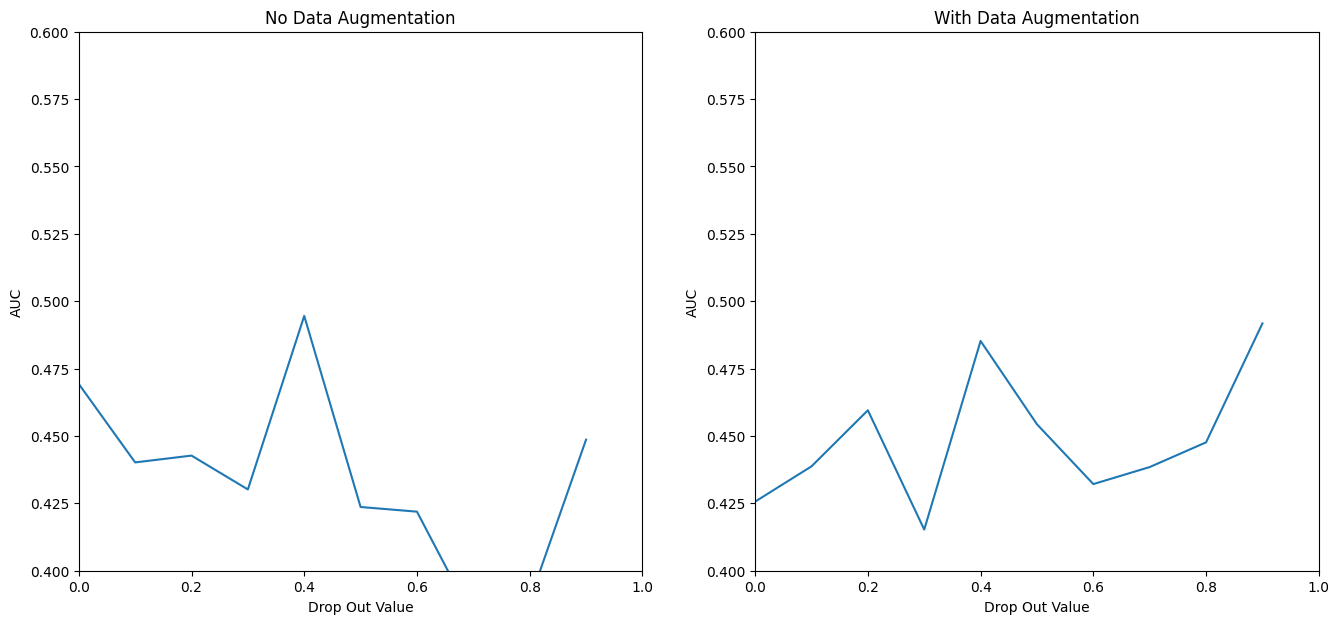

In [19]:
drop_out_values = np.arange(0, 1, 0.1)

plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.plot(drop_out_values, auc_list)
plt.xlabel('Drop Out Value')
plt.ylabel('AUC')
plt.xlim([0, 1])
plt.ylim([0.4, 0.6])
plt.title("No Data Augmentation")

plt.subplot(1, 2, 2)
plt.plot(drop_out_values, auc_with_data_aug)
plt.xlabel('Drop Out Value')
plt.ylabel('AUC')
plt.xlim([0, 1])
plt.ylim([0.4, 0.6])
plt.title('With Data Augmentation')

plt.show()

In [20]:
print(f"Best AUC with Data_Aug: {np.max(auc_with_data_aug)} at Drop_out = {round(drop_out_values[np.argmax(auc_with_data_aug)], 2)}" )
print(f"Best AUC No Data_Aug: {np.max(auc_list)} at Drop_out = {drop_out_values[np.argmax(auc_list)]}")

Best AUC with Data_Aug: 0.49175968766212463 at Drop_out = 0.9
Best AUC No Data_Aug: 0.49455079436302185 at Drop_out = 0.4


Drop out 0: (Data-Aug) Epoch 6: 0.512

Drop out 0.2: (Data-Aug) Epoch 9: 0.5112

Drop out 0.4: (Data-Aug) Epoch 1: 0.5149

Drop out 0.5: (no Data-Aug) Epoch 1: 0.54 !!!

Drop out 0.7: (Data-Aug) Epoch 2:  0.52